# 连接数据库

In [1]:
# get data from postgresql
import psycopg2
import pandas as pd
import numpy as np
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

conn = psycopg2.connect(
    host="192.168.1.144",
    port="5432",
    database="majiang",
    user="postgres",
    password="pgpassword")

# 设置运行参数

## 设置数据跨度
分析距今指定时间内的数据（不包含当日），单位为天。

In [2]:
# 查询距今 N 天内的数据进行分析
N = 10


## 指定数据过滤条件
+ 按照营收范围过滤
+ 按照门店的占用率(使用小时数/总小时数)过滤
+ 按照房间数量过滤(目标门店规模不能太大)

In [3]:
# 过滤条件
# 按营收过滤
REVENUE_LOWER = 0
REVENUE_UPPER = 999999999

# 按占用率过滤
OCCUPANCY_LOWER = 0.0
OCCUPANCY_UPPER = 1.0

# 按房间数过滤
ROOMS_LOWER = 0
ROOMS_UPPER = 999999999

# 数据提取

## 获取所有门店列表
实时获取当天数据， 得到所有门店列表， 记为`store_list`

In [4]:
# 获取店铺列表
import datetime
def get_store_list():
    # 获取今天的年月日
    year = datetime.datetime.now().year
    month = datetime.datetime.now().month
    day = datetime.datetime.now().day

    cur = conn.cursor()
    cur.execute(f"SELECT distinct(store_id) FROM fourfriends_data \
                WHERE city_code = '420100' \
                and year = '{year}' \
                and month = '{month}' \
                and day = '{day}' \
                and hour = '0' \
                ")
    shop_list = [i[0] for i in cur.fetchall()]
    cur.close()
    return shop_list

store_list = get_store_list()
print(store_list)

['0029a90e322d4ca4b6c8494ed5deeac6', '00392ebea4f140239145ebd489a10d07', '0394dfe25e30408a9a0c9c086e792783', '06ffeccb7eb64669bef955265e9de5be', '0727baf76bb240448442507f6846f0e9', '0761d2af8bc241559f2ae1ae326ed23e', '07d73c5fc33c469592bd077bdd7d84b1', '098d39250b884fb1b754a3685b9f2810', '0daeae227a83471e80d7b283827f825c', '0eb3f77d66ab445398748d27c9073916', '0fdf53d6fd43419c9c01fac79874a66f', '12e586161dfc4c4b8be4289ee5154043', '134c6f9683044a2eb6466fb0a7a0b329', '14f1cb9148c04ba09e30754d2c70a069', '160cc60301fb4aea8ba94d69024818a5', '17d673ba41b3484586a5dde7176c8821', '187b9493245f48b1a7822a2db93a2e4d', '1911bfceb61948e0931b3dcbf1184e94', '1a0df7be6196415f92f4a40e2d9568fa', '1b6aa8045ded48ccb5f7d576620d6d7c', '1b994a67db414a878a7e4eed2e2e6280', '1bce729d16af4385a6e6b3402c4e7129', '1c4f9c7b9b8a4203acaf261ca2e7d7d7', '1d7e7432fd284092b9e20d4463dd2843', '1fb686d695fd4f548bdaa575eb050149', '20fe54ae308d4eda9606dd4bacd94300', '2203a6b17119437d995c0000fafff256', '220b0f6377624c44800d47930d

In [5]:
def pre_process_df(df):
    # status列如果是’使用中， 转换成数字1， 否则是0
    # status列类型要保证是数字
    df['status'] = df['status'].apply(lambda x: 1 if x == '使用中' else 0)
    return df

In [6]:
# 获取n天内某个特定门店的所有原始数据
def get_store_data_in_n_days_df(store_id, days):
    s_year, s_month, s_day = get_date_n_days_ago(days)
    year, month, day = datetime.datetime.now().year, datetime.datetime.now().month, datetime.datetime.now().day
    query = f"""
    SELECT * FROM fourfriends_data 
        WHERE store_id = '{store_id}' 
        AND (CAST(year AS INTEGER) >= {s_year}) AND (CAST(year AS INTEGER) <= {year})
        AND (CAST(month AS INTEGER) >= {s_month}) AND (CAST(month AS INTEGER) <= {month})
        AND (CAST(day AS INTEGER) >= {s_day}) AND (CAST(day AS INTEGER) < {day});
    """     
    return pre_process_df(pd.read_sql_query(query, conn))

# 数据处理

In [7]:
# 获取n天前的年月日
def get_date_n_days_ago(days):
    target_date = datetime.datetime.now() - datetime.timedelta(days=days)
    return target_date.year, target_date.month, target_date.day

In [8]:
# 计算n天内某个特定门店的营收
def cal_revenue_df(store_data_in_n_days_df): 
    # 计算每行数据中status 和price的乘积，去掉索引列，然后求和
    # 得到的结果包含了行数列， 取第二列求和
    store_data_in_n_days_df['status'] = pd.to_numeric(store_data_in_n_days_df['status'], errors='coerce')
    store_data_in_n_days_df['price'] = pd.to_numeric(store_data_in_n_days_df['price'], errors='coerce')
    
    # Calculate the product of 'status' and 'price', then sum the results
    df = store_data_in_n_days_df['status'] * store_data_in_n_days_df['price']
    return df.sum()

In [9]:
# 计算n天内某个特定门店的占用率
def cal_occupied_rate_df(store_data_in_n_days_df):
    total = len(store_data_in_n_days_df)
    occupied = np.sum(store_data_in_n_days_df['status'] == 1)
    return occupied / total if total > 0 else 0

In [10]:
# 计算n天内所有门店的各项信息汇总
def cal_data_for_store_list_df(store_list, days):
    revenue_list = []
    for store_id in store_list:
        store_data_in_n_days_df = get_store_data_in_n_days_df(store_id, days)
        store_name = store_data_in_n_days_df['store_name'][0]
        room_count = store_data_in_n_days_df['room_id'].nunique()
        revenue = cal_revenue_df(store_data_in_n_days_df)
        occupied_rate = cal_occupied_rate_df(store_data_in_n_days_df)
        revenue_list.append({'store_name': store_name, 
                             'room_count': room_count, 
                             'revenue': revenue, 
                             'avg_rev': revenue / days,
                             'avg_rev_per_room': revenue / room_count / days,
                             'occupied_rate': occupied_rate})
    return revenue_list

data = cal_data_for_store_list_df(store_list, N)

KeyError: 0

In [ ]:
# 按revenue过滤数据
def filter_data_by_revenue(overall_data, lower_bound=0.0, upper_bound=999999999.0):
    return [x for x in overall_data if lower_bound <= x['revenue'] <= upper_bound]

data = filter_data_by_revenue(data, REVENUE_LOWER, REVENUE_UPPER)
print(data)

[{'store_name': '【武汉-卓尔总部店】', 'room_count': 7, 'revenue': np.float64(3659.0), 'avg_rev': np.float64(365.9), 'avg_rev_per_room': np.float64(52.271428571428565), 'occupied_rate': np.float64(0.21138211382113822)}, {'store_name': '【武汉-光谷商会大厦】', 'room_count': 7, 'revenue': np.float64(5020.0), 'avg_rev': np.float64(502.0), 'avg_rev_per_room': np.float64(71.71428571428571), 'occupied_rate': np.float64(0.22747252747252747)}, {'store_name': '【武汉-栗庙新村店】', 'room_count': 5, 'revenue': np.float64(532.0), 'avg_rev': np.float64(53.2), 'avg_rev_per_room': np.float64(10.64), 'occupied_rate': np.float64(0.043076923076923075)}, {'store_name': '【武汉-东原时光道店】', 'room_count': 5, 'revenue': np.float64(730.0), 'avg_rev': np.float64(73.0), 'avg_rev_per_room': np.float64(14.6), 'occupied_rate': np.float64(0.0467741935483871)}, {'store_name': '【武汉-光谷金融港店】', 'room_count': 8, 'revenue': np.float64(8600.0), 'avg_rev': np.float64(860.0), 'avg_rev_per_room': np.float64(107.5), 'occupied_rate': np.float64(0.307692307692

In [ ]:
# 按occupied_rate过滤数据
def filter_data_by_occupied_rate(overall_data, lower_bound=0.0, upper_bound=1.0):
    return [x for x in overall_data if lower_bound <= x['occupied_rate'] <= upper_bound]

data = filter_data_by_occupied_rate(data, OCCUPANCY_LOWER, OCCUPANCY_UPPER)
print(data)

[{'store_name': '【武汉-卓尔总部店】', 'room_count': 7, 'revenue': np.float64(3659.0), 'avg_rev': np.float64(365.9), 'avg_rev_per_room': np.float64(52.271428571428565), 'occupied_rate': np.float64(0.21138211382113822)}, {'store_name': '【武汉-光谷商会大厦】', 'room_count': 7, 'revenue': np.float64(5020.0), 'avg_rev': np.float64(502.0), 'avg_rev_per_room': np.float64(71.71428571428571), 'occupied_rate': np.float64(0.22747252747252747)}, {'store_name': '【武汉-栗庙新村店】', 'room_count': 5, 'revenue': np.float64(532.0), 'avg_rev': np.float64(53.2), 'avg_rev_per_room': np.float64(10.64), 'occupied_rate': np.float64(0.043076923076923075)}, {'store_name': '【武汉-东原时光道店】', 'room_count': 5, 'revenue': np.float64(730.0), 'avg_rev': np.float64(73.0), 'avg_rev_per_room': np.float64(14.6), 'occupied_rate': np.float64(0.0467741935483871)}, {'store_name': '【武汉-光谷金融港店】', 'room_count': 8, 'revenue': np.float64(8600.0), 'avg_rev': np.float64(860.0), 'avg_rev_per_room': np.float64(107.5), 'occupied_rate': np.float64(0.307692307692

In [ ]:
# 按room_count过滤数据
def filter_data_by_room_count(overall_data, lower_bound=0, upper_bound=999999999):
    return [x for x in overall_data if lower_bound <= x['room_count'] <= upper_bound]

data = filter_data_by_room_count(data, ROOMS_LOWER, ROOMS_UPPER)
print(data)

[{'store_name': '【武汉-卓尔总部店】', 'room_count': 7, 'revenue': np.float64(3659.0), 'avg_rev': np.float64(365.9), 'avg_rev_per_room': np.float64(52.271428571428565), 'occupied_rate': np.float64(0.21138211382113822)}, {'store_name': '【武汉-光谷商会大厦】', 'room_count': 7, 'revenue': np.float64(5020.0), 'avg_rev': np.float64(502.0), 'avg_rev_per_room': np.float64(71.71428571428571), 'occupied_rate': np.float64(0.22747252747252747)}, {'store_name': '【武汉-栗庙新村店】', 'room_count': 5, 'revenue': np.float64(532.0), 'avg_rev': np.float64(53.2), 'avg_rev_per_room': np.float64(10.64), 'occupied_rate': np.float64(0.043076923076923075)}, {'store_name': '【武汉-东原时光道店】', 'room_count': 5, 'revenue': np.float64(730.0), 'avg_rev': np.float64(73.0), 'avg_rev_per_room': np.float64(14.6), 'occupied_rate': np.float64(0.0467741935483871)}, {'store_name': '【武汉-光谷金融港店】', 'room_count': 8, 'revenue': np.float64(8600.0), 'avg_rev': np.float64(860.0), 'avg_rev_per_room': np.float64(107.5), 'occupied_rate': np.float64(0.307692307692

# 数据分析

In [ ]:
# 将所获数据按avg_revenue排序
def sort_data_by_avg_revenue(overall_data):
    return sorted(overall_data, key=lambda x: x['avg_rev'], reverse=True)

data_sort_by_avg_revenue = sort_data_by_avg_revenue(data)

In [ ]:
# 将所获数据按occupied_rate排序
def sort_data_by_occupied_rate(overall_data):
    return sorted(overall_data, key=lambda x: x['occupied_rate'], reverse=True)

data_sort_by_occupied_rate = sort_data_by_occupied_rate(data)

In [ ]:
# 将所获数据按avg_rev_per_room排序
def sort_data_by_avg_rev_per_room(overall_data):
    return sorted(overall_data, key=lambda x: x['avg_rev_per_room'], reverse=True)

data_sort_by_avg_rev_per_room = sort_data_by_avg_rev_per_room(data)
print(data_sort_by_avg_rev_per_room)

[{'store_name': '【武汉-华发中城荟店】', 'room_count': 5, 'revenue': np.float64(7230.0), 'avg_rev': np.float64(723.0), 'avg_rev_per_room': np.float64(144.6), 'occupied_rate': np.float64(0.4585365853658537)}, {'store_name': '【武汉-万龙中央公园店】', 'room_count': 5, 'revenue': np.float64(7125.0), 'avg_rev': np.float64(712.5), 'avg_rev_per_room': np.float64(142.5), 'occupied_rate': np.float64(0.46178861788617886)}, {'store_name': '【武汉-湘隆时代广场店】', 'room_count': 9, 'revenue': np.float64(12500.0), 'avg_rev': np.float64(1250.0), 'avg_rev_per_room': np.float64(138.88888888888889), 'occupied_rate': np.float64(0.45076784101174344)}, {'store_name': '【武汉-航天商务广场店】', 'room_count': 5, 'revenue': np.float64(6660.0), 'avg_rev': np.float64(666.0), 'avg_rev_per_room': np.float64(133.2), 'occupied_rate': np.float64(0.4292682926829268)}, {'store_name': '【武汉-广信万汇城店】', 'room_count': 9, 'revenue': np.float64(11307.0), 'avg_rev': np.float64(1130.7), 'avg_rev_per_room': np.float64(125.63333333333333), 'occupied_rate': np.float64(0

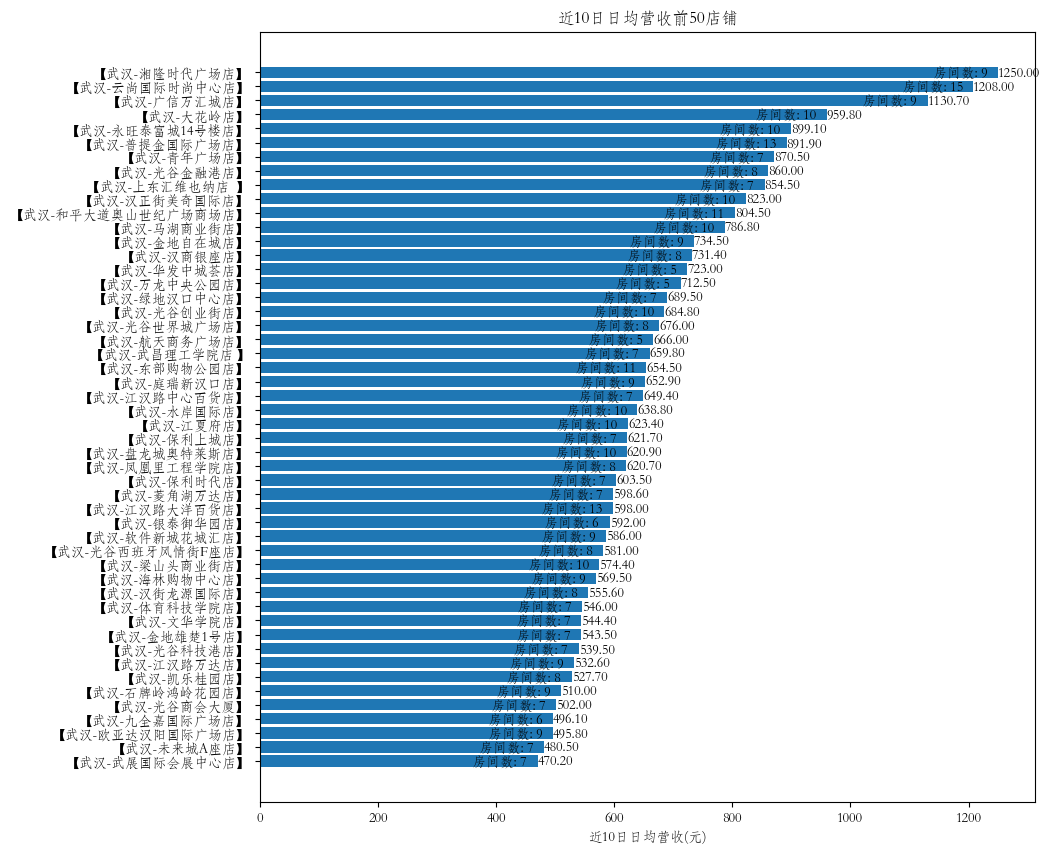

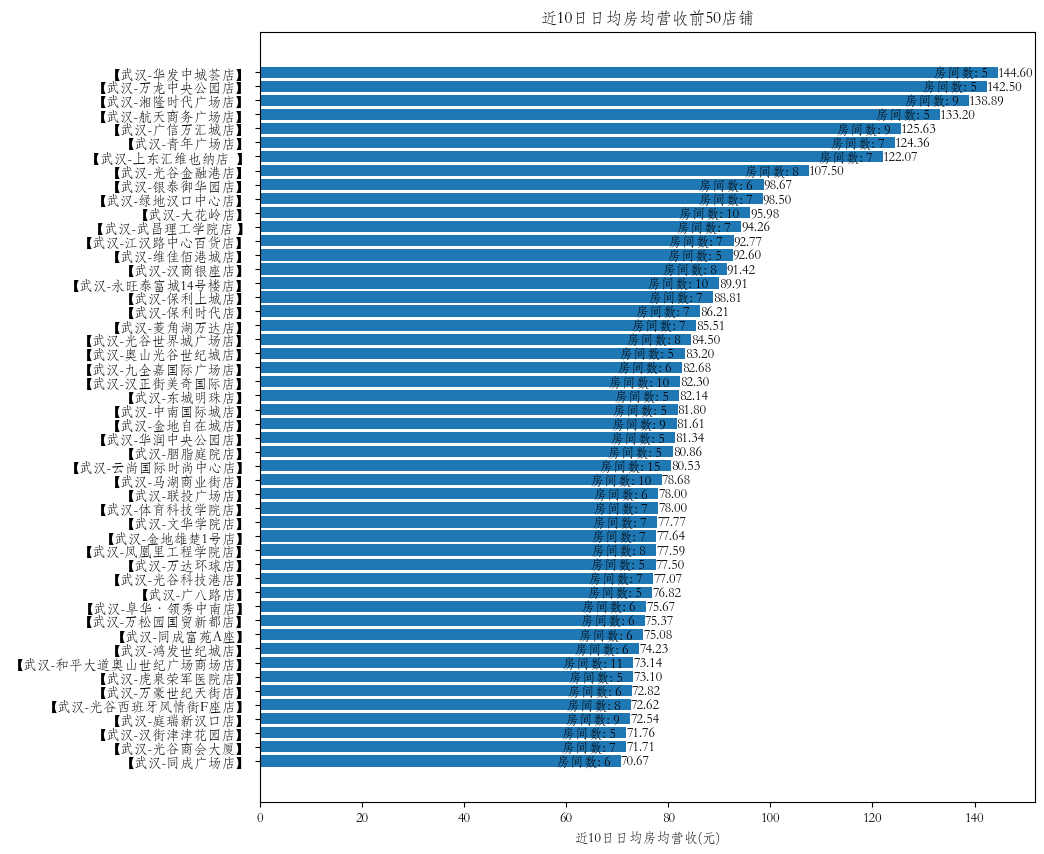

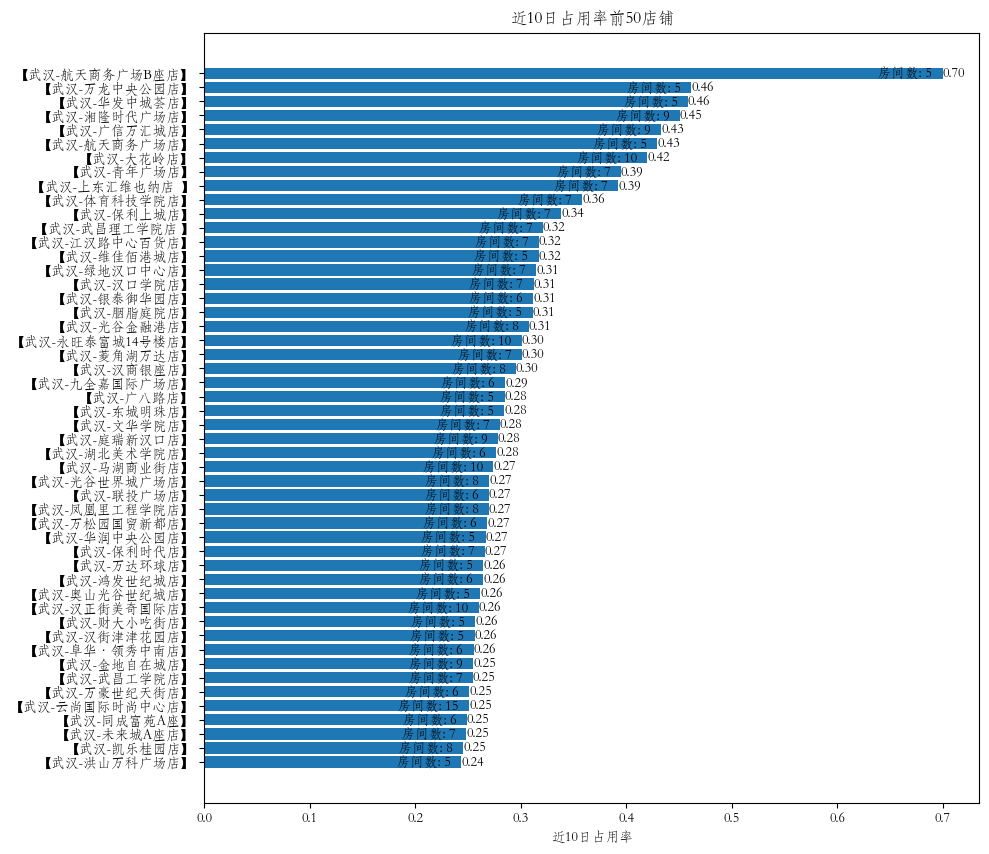

In [ ]:
# 将排序后的数据绘制成图表
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontManager

def plot_data(data, xdata, xlabel, title):
    plt.rcParams['font.sans-serif'] = ['STFangsong']
    plt.rcParams['axes.unicode_minus'] = False
    
    plt.figure(figsize=(10, 10))  # 宽度为10英寸，高度为30英寸
    data.reverse()
    # store_name 在y轴， avg_rev 在x轴， avg_rev 高的在上面
    store_name = [x['store_name'] for x in data]
    xdata = [x[xdata] for x in data]
    # 每个bar后面显示具体数值, 和room数量
    for i in range(len(xdata)):
        plt.text(xdata[i], i, f'{xdata[i]:.2f}', ha='left', va='center')
        plt.text(xdata[i], i, f'房间数: {data[i]["room_count"]}   ', ha='right', va='center')
    plt.barh(store_name, xdata)
    plt.xlabel(xlabel)
    plt.ylabel('')
    plt.title(title)
    plt.show()
    

plot_data(data_sort_by_avg_revenue[:50], 'avg_rev', f'近{N}日日均营收(元)', f'近{N}日日均营收前50店铺')
plot_data(data_sort_by_avg_rev_per_room[:50], 'avg_rev_per_room', f'近{N}日日均房均营收(元)', f'近{N}日日均房均营收前50店铺')
plot_data(data_sort_by_occupied_rate[:50], 'occupied_rate', f'近{N}日占用率', f'近{N}日占用率前50店铺')